In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. MLP sin variables exogenas
---

In [2]:
df = pd.read_csv('./data/daily_hospitalized_patients.csv', parse_dates=['date'])
df = df.sort_values('date')
# Extreamos los pacientes y lo convertimos en una matriz columna
y = df['num_patients'].values.reshape(-1, 1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          728 non-null    datetime64[ns]
 1   num_patients  728 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.5 KB


In [4]:
# --- Crear ventanas de entrada (21 días) y salida (7 días) ---
def create_lags(series, n_lags=21, n_future=7):
    """
    Convierte una serie temporal en un conjunto supervisado multistep.
    X: ventanas de tamaño n_lags
    y: siguientes n_future valores a predecir
    """
    X, y = [], []
    for i in range(n_lags, len(series) - n_future + 1):
        X.append(series[i - n_lags:i, 0])          # 21 días previos
        y.append(series[i:i + n_future, 0])        # próximos 7 días
    return np.array(X), np.array(y)

# --- Escalar la serie ---
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# --- Crear ventanas ---
n_lags = 21
n_future = 7
X, y_lagged = create_lags(y_scaled, n_lags, n_future)

In [5]:

# División temporal 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_lagged, test_size=0.2, shuffle=False
)

In [6]:
# --- Entrenar MLP ---
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42, 
    early_stopping=True
)
mlp.fit(X_train, y_train);

In [7]:
# --- Predicción sobre el conjunto de test ---
y_pred = mlp.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

# --- Métricas ---
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Evaluación (7 días): MAE={mae:.2f}, R²={r2:.3f}")

Evaluación (7 días): MAE=19.98, R²=0.101


In [8]:
y_test_inv.shape

(987, 1)

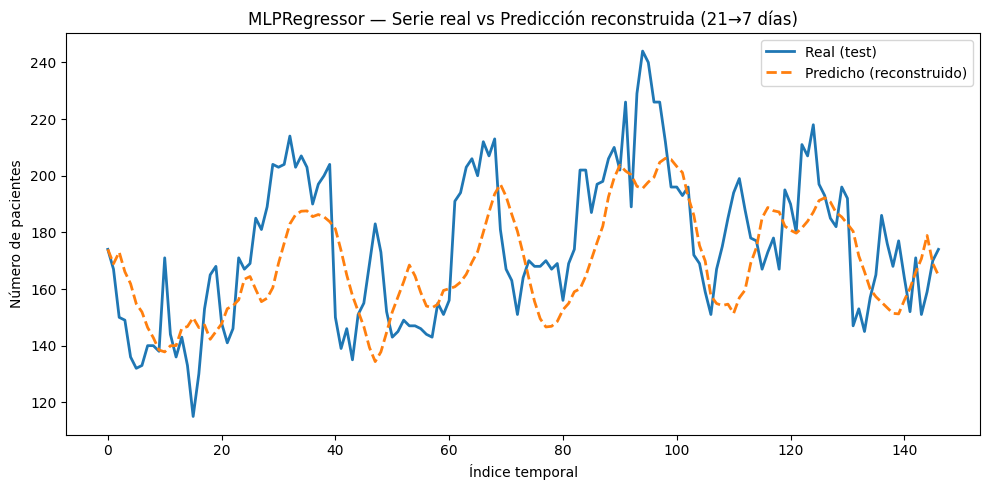

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Predicciones ---
y_pred = mlp.predict(X_test)

# --- Invertir el escalado ---
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

n_steps_out = 7

# --- Reconstruir serie predicha (promediando solapamientos) ---
n_test_points = len(y_test_inv) + n_steps_out - 1
y_pred_recon = np.zeros(n_test_points)
counts = np.zeros(n_test_points)

for i in range(len(y_pred_inv)):
    for j in range(n_steps_out):
        y_pred_recon[i + j] += y_pred_inv[i, j]
        counts[i + j] += 1

y_pred_recon = y_pred_recon / np.maximum(counts, 1)

# --- Calcular inicio del test ---
# len(y_train) = cantidad de muestras previas a la división 80/20
start_test = len(y) - len(y_test_inv) - n_steps_out + 1

# Porción real equivalente al test
y_test_segment = y[start_test : start_test + len(y_pred_recon)]

# --- Graficar ---
plt.figure(figsize=(10, 5))
plt.plot(y_test_segment, label="Real (test)", color="#1f77b4", linewidth=2)
plt.plot(y_pred_recon, label="Predicho (reconstruido)", color="#ff7f0e", linestyle="--", linewidth=2)

plt.title("MLPRegressor — Serie real vs Predicción reconstruida (21→7 días)")
plt.xlabel("Índice temporal")
plt.ylabel("Número de pacientes")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# --- Tomamos los últimos 21 valores conocidos ---
last_window = y_scaled[-n_lags:].reshape(1, -1)   # (1, 21)

# --- Predicción directa de los próximos 7 días ---
future_preds_scaled = mlp.predict(last_window)[0]  # salida de tamaño (7,)

# --- Invertir la escala ---
future_preds_inv = scaler.inverse_transform(
    np.array(future_preds_scaled).reshape(-1, 1)
).flatten()

# --- Índices para graficar o analizar ---
train_idx = np.arange(len(y_train))
test_idx = np.arange(len(y_train), len(y_train) + len(y_test))
future_idx = np.arange(len(y_train) + len(y_test),
                       len(y_train) + len(y_test) + n_future)

# --- Serie completa inversa ---
y_inv = scaler.inverse_transform(y_scaled)

# --- Opcional: mostrar resultados ---
print("Predicciones para los próximos 7 días:")
for i, val in enumerate(future_preds_inv, 1):
    print(f"Día +{i}: {val:.2f}")


Predicciones para los próximos 7 días:
Día +1: 170.57
Día +2: 171.80
Día +3: 174.33
Día +4: 175.46
Día +5: 180.19
Día +6: 178.71
Día +7: 175.67


In [11]:
print("\nPredicción a 7 días:")
for i, val in enumerate(future_preds_inv, start=1):
    print(f"  Día {i:}: {round(val)} pacientes")



Predicción a 7 días:
  Día 1: 171 pacientes
  Día 2: 172 pacientes
  Día 3: 174 pacientes
  Día 4: 175 pacientes
  Día 5: 180 pacientes
  Día 6: 179 pacientes
  Día 7: 176 pacientes


# 2. MLP con variables exogenas
---

In [12]:
df_weather = pd.read_csv('./data/HDHI_pollution_data.csv')
df_weather['DATE'] = pd.to_datetime(
  df_weather['DATE'], 
  dayfirst=False, 
  errors='coerce'
)

In [13]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], errors='coerce')

# Columnas de interés (ajusta nombres si en tu CSV son distintos)
wanted = ['DATE', 'AQI', 'MAX TEMP', 'MIN TEMP', 'HUMIDITY']
present = [c for c in wanted if c in df_weather.columns]

# Seleccionar y, si hay duplicados por fecha, agregarlos por media
dfw_sel = df_weather[present].copy()
if dfw_sel['DATE'].duplicated().any():
    dfw_sel = dfw_sel.groupby('DATE', as_index=False).mean()

# Merge por fecha (left join para conservar daily_counts)
df_exogen = pd.merge(df, dfw_sel, left_on='date', right_on='DATE', how='left')

# Limpiar/renombrar columnas para análisis posterior
df_exogen = df_exogen.drop(columns=['DATE'], errors='ignore').rename(
    columns={
        'AQI': 'aqi',
        'MAX TEMP': 'max_temp',
        'MIN TEMP': 'min_temp',
        'HUMIDITY': 'humidity'
    }
)

# Forzar numérico en las columnas añadidas
for col in ['aqi', 'max_temp', 'min_temp', 'humidity']:
    if col in df_exogen.columns:
        df_exogen[col] = pd.to_numeric(df_exogen[col], errors='coerce')


mean_humidity = df_exogen['humidity'].mean()
df_exogen['humidity'] = df_exogen['humidity'].fillna(mean_humidity).round(2)

df_exogen.head()


,date,num_patients,aqi,max_temp,min_temp,humidity
0,2017-04-01,30,52,40,24,16.0
1,2017-04-02,45,59,40,21,14.0
2,2017-04-03,65,70,39,22,14.0
3,2017-04-04,78,70,39,23,23.0
4,2017-04-05,71,88,36,20,51.0


In [14]:
df_exogen = df_exogen.sort_values('date')
# Extraemos los pacientes y lo convertimos en una matriz columna
y = df_exogen['num_patients'].values.reshape(-1, 1)

In [15]:
# Escaladores
scaler_y = MinMaxScaler()
scaler_x = MinMaxScaler()

# Escalar la variable objetivo 
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Preprocesamos las variables exogenas
df_exogen_proc = df_exogen.copy()

# Si hay columnas de fecha, convertirlas a componentes numéricos
for col in df_exogen_proc.select_dtypes(include=['datetime64[ns]']).columns:
    df_exogen_proc[f'{col}_day'] = df_exogen_proc[col].dt.day
    df_exogen_proc[f'{col}_month'] = df_exogen_proc[col].dt.month
    df_exogen_proc[f'{col}_weekday'] = df_exogen_proc[col].dt.weekday
    df_exogen_proc = df_exogen_proc.drop(columns=[col])

# Asegurar todo numérico
df_exogen_proc = df_exogen_proc.apply(pd.to_numeric, errors='coerce').fillna(0)



In [16]:
df_exogen_proc

,num_patients,aqi,max_temp,min_temp,humidity,date_day,date_month,date_weekday
0,30,52,40,24,16.0,1,4,5
1,45,59,40,21,14.0,2,4,6
2,65,70,39,22,14.0,3,4,0
3,78,70,39,23,23.0,4,4,1
4,71,88,36,20,51.0,5,4,2
...,...,...,...,...,...,...,...,...
723,171,69,27,15,51.0,25,3,0
724,151,98,29,15,51.0,26,3,1
725,159,93,30,16,35.0,27,3,2
726,170,103,31,17,32.0,28,3,3


In [17]:
# Escalar exógenas
X_exogen_scaled = scaler_x.fit_transform(df_exogen_proc.values)

# Creamos las ventanas
n_lags = 7
X_lags, y_target = create_lags(y_scaled, n_lags)
X_exogen_lagged = X_exogen_scaled[n_lags:]

# Alinear tamaños
min_len = min(len(X_lags), len(X_exogen_lagged))
X_lags = X_lags[-min_len:]
X_exogen_lagged = X_exogen_lagged[-min_len:]
y_target = y_target[-min_len:]

# Combinar lags + exógenas
X_total = np.hstack([X_lags, X_exogen_lagged]) 

# División temporal
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_target, test_size=0.2, shuffle=False
)

In [18]:
# Entrenamos el modelo
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42,
    early_stopping=True
);
mlp.fit(X_train, y_train);

In [19]:
# Realizamos las predicciones sobre el conjunto de test
y_pred = mlp.predict(X_test)

# Invertir escalado
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Métricas
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Evaluación en test:")
print(f"MAE = {mae:.2f}")
print(f"R²  = {r2:.3f}")

Evaluación en test:
MAE = 11.89
R²  = 0.651


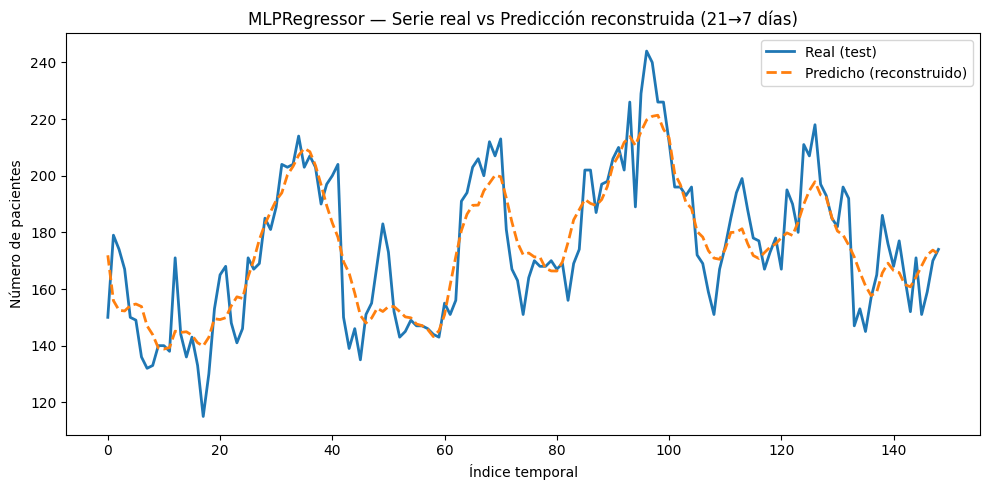

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --- Predicciones ---
y_pred = mlp.predict(X_test)

# --- Invertir el escalado ---
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

n_steps_out = 7

# --- Reconstruir serie predicha (promediando solapamientos) ---
n_test_points = len(y_test_inv) + n_steps_out - 1
y_pred_recon = np.zeros(n_test_points)
counts = np.zeros(n_test_points)

for i in range(len(y_pred_inv)):
    for j in range(n_steps_out):
        y_pred_recon[i + j] += y_pred_inv[i, j]
        counts[i + j] += 1

y_pred_recon = y_pred_recon / np.maximum(counts, 1)

# --- Calcular inicio del test ---
# len(y_train) = cantidad de muestras previas a la división 80/20
start_test = len(y) - len(y_test_inv) - n_steps_out + 1

# Porción real equivalente al test
y_test_segment = y[start_test : start_test + len(y_pred_recon)]

# --- Graficar ---
plt.figure(figsize=(10, 5))
plt.plot(y_test_segment, label="Real (test)", color="#1f77b4", linewidth=2)
plt.plot(y_pred_recon, label="Predicho (reconstruido)", color="#ff7f0e", linestyle="--", linewidth=2)

plt.title("MLPRegressor — Serie real vs Predicción reconstruida (21→7 días)")
plt.xlabel("Índice temporal")
plt.ylabel("Número de pacientes")
plt.legend()
plt.tight_layout()
plt.show()
